In [14]:
import pandas as pd
import os
import re
import sys
import matplotlib.pyplot as plt
import numpy as np

In [15]:
sys.path.append('../statistics')
from mylib import mylibrary as ml
current_dir = !pwd
current_dir = current_dir[0]
current_dir

'/var/tmp/vcloud-q3b/statistics_final'

In [179]:
versions = {"orig" : "/original", "none":"/approx_of_abstr_of/","approx" : "/approx_on_abstr_of/", "abstr":"/approx_of_abstr_on/", "both":"/approx_on_abstr_on/", "lazy" : "/approx_on_abstr_on_lazy" }

In [180]:
def merge_benchmark_families(adict):
    benchmarks = ['2017-Preiner-UltimateAutomizer',
 '2017-Preiner-keymaera',
 '2017-Preiner-psyco',
 '2017-Preiner-scholl-smt08',
 '2017-Preiner-tptp',
 '20170501-Heizmann-UltimateAutomizer',
 '2018-Preiner-cav18',
 '20190429-UltimateAutomizerSvcomp2019',
 '2020-Preiner-fmcad20',
 '20210301-Alive2',
 '20210301-Alive2-partial-undef',
 '20230321-UltimateAutomizerSvcomp2023',
 'llvm13-smtlib',
 'wintersteiger']
    return pd.concat([adict[x] for x in benchmarks], ignore_index=True)

In [181]:
frames = {}

for v in versions:
    frames[v] = merge_benchmark_families(ml.dict_to_df(ml.get_data( ml.get_csv(current_dir+versions[v]))))

# Get set of benchmarks that fail (not in my parts of code)

In [182]:
def get_failing_benchmarks(df):
    failig_benchmarks = df[~df['result'].isin(['true', 'false', 'TIMEOUT'])]
    return set(failig_benchmarks['benchmarkfile'])

In [183]:
def get_fails(frames):
    fail = set()
    for df in frames.values():
        fail = fail.union(get_failing_benchmarks(df))
    return fail

In [184]:
fails = get_fails(frames)
len(fails)


33

In [185]:
def get_num_of_benchmarks(adict):
    counter = 0
    for df in adict.values():
        counter += df.shape[0]
    return counter

In [186]:
def remove_fails_from_df(df, fails):
    return df[~df['benchmarkfile'].isin(fails)]

In [187]:
def remove_fails_form_dict(benchm_dict, fails):
    for benchname in benchm_dict:
        benchm_dict[benchname] = remove_fails_from_df(benchm_dict[benchname], fails)
    return benchm_dict

In [197]:
def get_sum_df(path):
    csv = ml.get_csv(path)
    df = ml.dict_to_df(ml.get_data(csv))
    #fails = get_fails(frames)
    #df = remove_fails_form_dict(df, fails)
    sumdata = ml.sum_data(df)
    timedata = ml.time_data(df)
    sumdata = sumdata.reindex(sorted(sumdata.columns), axis=1)
    timedata = timedata.reindex(sorted(timedata.columns), axis=1)
    #sumdata = sumdata.drop(['sat', 'unsat', 'segfault', 'other', 'timeout']).T
    return sumdata, timedata
    

In [198]:
sums = []
for v in versions:
    sumdata = get_sum_df(current_dir+versions[v])[0]
    sumdata = sumdata.drop(['sat', 'unsat', 'segfault', 'other', 'timeout']).T.rename(columns={"solved": v})
    sums.append(sumdata)

# Join

In [199]:
merged = sums[0]
for df in sums[1:]:
    merged = pd.merge(merged, df, left_index=True, right_index=True, suffixes=('', '_2'))
    
cols_to_drop = [col for col in merged.columns if col.endswith('_2')]

# Drop these columns
merged.drop(cols_to_drop, axis=1, inplace=True)

In [200]:
total_row = merged.sum()
total_row

total     6158
orig      5842
none      5832
approx    5859
abstr     5830
both      5857
lazy      5848
dtype: int64

In [201]:
merged.loc['Total'] = total_row
ml.write_to_file("/home/xschwar3/dp/statistics/comparison2.tex", merged.to_latex())
merged

,total,orig,none,approx,abstr,both,lazy
2017-Preiner-UltimateAutomizer,153,153,153,153,153,153,153
2017-Preiner-keymaera,4035,4008,4010,4010,4009,4010,3999
2017-Preiner-psyco,194,151,152,152,152,152,153
2017-Preiner-scholl-smt08,374,288,287,287,286,286,284
2017-Preiner-tptp,73,73,73,73,73,73,73
20170501-Heizmann-UltimateAutomizer,131,110,109,109,109,109,111
2018-Preiner-cav18,600,563,563,563,563,563,565
20190429-UltimateAutomizerSvcomp2019,96,86,86,86,86,86,86
2020-Preiner-fmcad20,165,128,127,128,129,127,126
20210301-Alive2,4,0,0,0,0,0,0


# CPU time comparison

In [202]:
def create_df_comparison(version1, version2, current_dir):
    
    adict1 = ml.dict_to_df(ml.get_data( ml.get_csv(current_dir + versions[version1])))
    adict2 = ml.dict_to_df(ml.get_data( ml.get_csv(current_dir+versions[version2])))
    
    #fails = get_fails(frames)
    #adict1 = remove_fails_form_dict(adict1, fails)
    #adict2 = remove_fails_form_dict(adict2, fails)
    df1 = merge_benchmark_families(adict1)
    df2 = merge_benchmark_families(adict2)
    #df2 = df2[df2['result'].isin(['true', 'false', 'TIMEOUT'])]
    #df1 = df1[df1['result'].isin(['true', 'false', 'TIMEOUT'])]
    intersection_df = pd.merge(df1, df2, on='benchmarkfile', how='inner')
    return intersection_df
    
    


In [203]:
def show_plot(df, column, filename):
    
    #timeout_df = df[df['result_x'].isin(['TIMEOUT']) | df['result_y'].isin(['TIMEOUT'])]
    #sat_df = df[df['result_x'].isin(['true']) & df['result_y'].isin(['true'])]
    #unsat_df = df[df['result_x'].isin(['false']) & df['result_y'].isin(['false'])]
    
    # Data
    x = df[column+"_x"]
    y = df[column+"_y"]
    
    
    print(len(x))
    print(len(y))
    ref_line = [i for i in range(0, 1000)]  # Reference line (y=x)

    # Scatter plot
    plt.scatter(x, y,  label='Data points')
    #x = sat_df[column+"_x"]
    #y = sat_df[column+"_y"]
    #plt.scatter(x, y, color='yellow', label='Data points')
    #x = timeout_df[column+"_x"]
    #y = timeout_df[column+"_y"]
    #plt.scatter(x, y, color='green', label='Data points')
    
    
    
    if column == "cputime":
        ref_line = [i for i in range(0, 300)]  # Reference line (y=x)
        # Add red vertical and horizontal lines at x=300 and y=300
        plt.axvline(x=300,color='red', linestyle='--',linewidth=0.5)
        plt.axhline(y=300, color='red', linestyle='--', linewidth=0.5)

        # Change tick labels on x-axis and y-axis at point 300 to "timelimit"
        plt.xticks([300], ['timelimit'])
        plt.yticks([300], ['timelimit'])
        
    
    
    plt.xlabel('original Q3B')
    plt.ylabel('Q3B -- approx on, abstr off')
    plt.title('CPU time comparison')
    
    
    # Set scale to logarithmic
    plt.xscale('log')
    plt.yscale('log')
    # Reference line
    plt.plot(ref_line, ref_line, label='Reference line', color='red', linestyle='-')

    plt.grid(True)
    plt.savefig(filename+".pdf", format="pdf", bbox_inches="tight")
    #plt.show()
    return plt

6158
6158


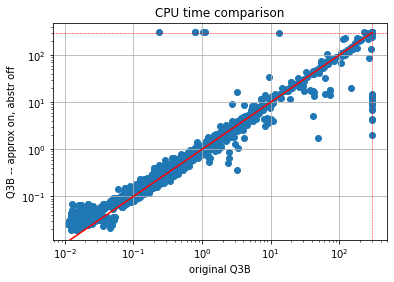

In [204]:
plt = show_plot(create_df_comparison('orig', 'approx', current_dir), 'cputime', 'orig-approx')

In [205]:
df = create_df_comparison('orig', 'approx', current_dir)
len(df[df['result_x'].isin(['true']) & df['result_y'].isin(['true'])])

603

In [206]:
len(df[df['result_x'].isin(['false']) & df['result_y'].isin(['false'])])

5224

In [207]:
len(df[df['result_x'].isin(['TIMEOUT']) & df['result_y'].isin(['true', 'false'])])

32

In [208]:
len(df[df['result_x'].isin(['false', 'true']) & df['result_y'].isin(['TIMEOUT'])])

7

In [209]:
len(df[df['result_x'].isin(['TIMEOUT']) & df['result_y'].isin(['TIMEOUT'])])

260

In [210]:
len(df[df['result_x'].isin(['TIMEOUT']) | df['result_y'].isin(['TIMEOUT'])])

300

# Cross comparison

In [211]:
def uniquely_solved(df1, df2):
    solved1 = df1[df1['result'].isin(['true', 'false'])] # ty co vyresil levej
    unsolved2 = df2[~df2['result'].isin(['true', 'false'])]
    intersection_df = pd.merge(solved1, unsolved2, on='benchmarkfile', how='inner')
    return intersection_df.shape[0]

In [212]:
data = {}
for s1 in versions:
    data[s1] = []
    for s2 in versions:
        adict1 = ml.dict_to_df(ml.get_data( ml.get_csv(current_dir + versions[s1])))
        adict2 = ml.dict_to_df(ml.get_data( ml.get_csv(current_dir+versions[s2])))
        fails = get_fails(frames)
        adict1 = remove_fails_form_dict(adict1, fails)
        adict2 = remove_fails_form_dict(adict2, fails)
        df1 = merge_benchmark_families(adict1)
        df2 = merge_benchmark_families(adict2)
        data[s1].append(uniquely_solved(df1, df2))

In [213]:
labels = list(versions.keys())
df = pd.DataFrame(data, index=labels,dtype=object)
#np.fill_diagonal(df.values, "x")
cross_comparison = df.T
cross_comparison

,orig,none,approx,abstr,both,lazy
orig,0,6,7,8,9,32
none,4,0,2,5,3,28
approx,32,29,0,33,2,27
abstr,4,3,4,0,5,30
both,32,28,0,32,0,25
lazy,45,43,15,47,15,0


In [154]:
#ml.write_to_file("/home/xschwar3/dp/statistics/cross_comparison.tex", cross_comparison.to_latex())


# Benchmarks (approx & abstr solve, both not)

In [120]:
def get_df(path, frames):
    adict1 = ml.dict_to_df(ml.get_data( ml.get_csv(path)))
    fails = get_fails(frames)
    adict1 = remove_fails_form_dict(adict1, fails)
    df1 = merge_benchmark_families(adict1)
    return df1

In [123]:
both = get_df(current_dir + versions['both'], frames)
abstr = get_df(current_dir + versions['abstr'], frames)
approx = get_df(current_dir + versions['approx'], frames)

In [129]:
solved_by_approx_abstr  = pd.merge(abstr, approx, on='benchmarkfile', how='inner')

In [130]:
solved_by_approx_abstr

,benchmarkfile,result_x,cputime_x,walltime_x,memory_x,result_y,cputime_y,walltime_y,memory_y
0,2017-Preiner-UltimateAutomizer/MADWiFi-encode_...,false,0.194449,0.103547,106.713088,false,0.192653,0.106339,104.574976
1,2017-Preiner-UltimateAutomizer/MADWiFi-encode_...,false,0.193649,0.103094,106.606592,false,0.192103,0.102458,106.713088
2,2017-Preiner-UltimateAutomizer/Primes_true-unr...,false,0.155006,0.111575,100.335616,false,0.133249,0.089672,101.208064
3,2017-Preiner-UltimateAutomizer/Primes_true-unr...,false,1.028561,0.410689,172.703744,false,0.977896,0.408048,161.710080
4,2017-Preiner-UltimateAutomizer/Primes_true-unr...,false,0.028969,0.029377,18.894848,false,0.028564,0.028974,18.898944
...,...,...,...,...,...,...,...,...,...
6120,wintersteiger/fmsd13/fixpoint/fixpoint-usb-phy...,false,0.201581,0.201998,24.526848,false,0.142845,0.143263,24.477696
6121,wintersteiger/fmsd13/fixpoint/fixpoint-usb-phy...,false,0.359944,0.360297,29.913088,false,0.464197,0.464606,29.913088
6122,wintersteiger/fmsd13/fixpoint/fixpoint-usb-phy...,false,0.687185,0.687523,35.102720,false,0.663946,0.664292,35.184640
6123,wintersteiger/fmsd13/fixpoint/fixpoint-usb-phy...,false,1.369999,1.370340,40.288256,false,1.427269,1.427637,40.300544


In [132]:
intersection = pd.merge(both, solved_by_approx_abstr, on='benchmarkfile', how='inner')

In [147]:
probl = intersection[intersection['result'].isin(["TIMEOUT"])  & intersection['result_x'].isin(['true', 'false']) & intersection['result_y'].isin(['true', 'false'])]


In [150]:
probl

,benchmarkfile,result,cputime,walltime,memory,result_x,cputime_x,walltime_x,memory_x,result_y,cputime_y,walltime_y,memory_y
5643,2020-Preiner-fmcad20/inv/invcheck_ic_bvashr_x_...,TIMEOUT,301.94754,100.735544,1005.355008,false,277.013349,103.927524,1042.8416,false,270.400482,100.181184,1006.57152


# Lazy evaluation

In [163]:
lazy_path = current_dir + "/approx_on_abstr_on_lazy"

In [166]:
sumdata = get_sum_df(lazy_path)[0]
sumdata = sumdata.drop(['sat', 'unsat', 'segfault', 'other', 'timeout']).T.rename(columns={"solved": v})

In [167]:
sumdata

,2017-Preiner-UltimateAutomizer,2017-Preiner-keymaera,2017-Preiner-psyco,2017-Preiner-scholl-smt08,2017-Preiner-tptp,20170501-Heizmann-UltimateAutomizer,2018-Preiner-cav18,20190429-UltimateAutomizerSvcomp2019,2020-Preiner-fmcad20,20210301-Alive2,20210301-Alive2-partial-undef,20230321-UltimateAutomizerSvcomp2023,llvm13-smtlib,wintersteiger
total,153,4035,194,356,73,127,600,96,165,1,3,140,9,173
unsat,137,3895,49,45,56,91,565,71,126,0,1,122,1,86
sat,16,104,104,238,17,20,0,15,0,0,0,13,0,75
solved,153,3999,153,283,73,111,565,86,126,0,1,135,1,161
timeout,0,36,41,73,0,16,35,10,39,1,2,5,8,12
segfault,0,0,0,0,0,0,0,0,0,0,0,0,0,0
other,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [172]:
sums[4]

,total,both
2017-Preiner-UltimateAutomizer,153,153
2017-Preiner-keymaera,4035,4010
2017-Preiner-psyco,194,152
2017-Preiner-scholl-smt08,356,286
2017-Preiner-tptp,73,73
20170501-Heizmann-UltimateAutomizer,127,109
2018-Preiner-cav18,600,563
20190429-UltimateAutomizerSvcomp2019,96,86
2020-Preiner-fmcad20,165,127
20210301-Alive2,1,0


In [177]:
sumdata, timedata = ml.copmare_dfs(current_dir+versions['both'], "both, not lazy", lazy_path, "both, lazy")

In [178]:
sumdata